In [1]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing
import tensorflow as tf

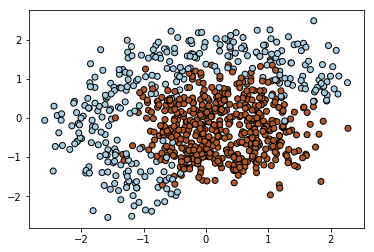

In [2]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], cmap=plt.cm.Paired, c=y, edgecolors='black')

plt.show()

In [3]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
xx = xx.astype(np.float32)
yy = yy.astype(np.float32)

def visualize(X, y, w, loss, n_iter):
    plt.clf()
    fig = plt.figure(figsize=(20, 8))
    
    with tf.Session() as sess:
        Z = sess.run(classify(np.c_[xx.ravel(), yy.ravel()], w))
        
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.close(fig)


**Your task starts here**

First, let's write a function that predicts class for given X.

Since the problem above isn't linearly separable, we add quadratic features to the classifier. This transformation is implemented in the __expand__ function.

__Don't forget to expand X inside classify and other functions__

Sample classification should not be much harder than computation of sign of dot product.

In [4]:
def expand(X):
    X_ = tf.zeros((X.shape[0], 6))
    X0 = tf.transpose(tf.gather(tf.transpose(X), [0]))
    X1 = tf.transpose(tf.gather(tf.transpose(X), [1]))
    X_ = tf.concat([X, X ** 2, X0 * X1, tf.ones(shape=(X.shape[0], 1), dtype=tf.float32)], axis=1)
    return X_

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    """
    
    y = tf.tensordot(expand(X), w, axes=1)
    # default tf.sign would give 0 in x = 0
    return tf.map_fn(lambda x: tf.cond(x >= 0., lambda: 1., lambda: -1.), y)

In [5]:
with tf.Session() as sess:
    w_ = np.array([1, 1, 1, 1, 1, 1], dtype=np.float32)
    X_ = np.array([[1, 2], [1, 2], [1, 2]], dtype=np.float32)
    
    expected = np.array([1., 1., 1.], dtype=np.float32)
    actual = sess.run(classify(X_, w_))

    if np.count_nonzero(actual - expected) != 0:
        print('Fail')
        print('expected {0}, actual {1}'.format(expected, actual))
    else:
        print('Ok')

Ok


The loss you should try to minimize is the Hinge Loss:

$$ L =  {1 \over N} \sum_{i=1}^N max(0,1-y_i \cdot  w^T x_i) $$



In [6]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    """
    margin = y * tf.tensordot(expand(X), w, axes=1)
    
    maxs = tf.maximum(tf.zeros(shape=y.shape), tf.ones(shape=y.shape) - margin)
    n_samples = y.shape[0]
    
    return tf.reduce_sum(maxs) / n_samples
    
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weight.
    """
    X_ = expand(X)

    dot = y * tf.squeeze(tf.tensordot(X_, w, axes=1))
    idx_errors = tf.squeeze(tf.where(tf.less(dot, tf.ones_like(y))))
    
    n_errors = tf.reduce_sum(tf.cast(idx_errors, tf.float32))
    
    xs = tf.gather(X_, idx_errors)
    ys = tf.gather(y, idx_errors)
    cums = tf.transpose(
            - tf.map_fn(lambda x: tf.multiply(x, ys), tf.transpose(xs))
            )
    
    n_samples = y.shape[0]
    
    return tf.cond(tf.equal(n_errors, 0), 
            lambda: tf.zeros_like(w), 
            lambda: (tf.reduce_sum(cums, axis=0) / n_samples))

### test on loss

In [7]:
with tf.Session() as sess:
    w_ = np.array([1, 1, 1, 1, 1, 1], dtype=np.float32)
    X_ = np.array([[1, 2], [1, 2], [1, 2]], dtype=np.float32)
    y_ = np.array([-1, -1, -1], dtype=np.float32)
    
    expected = 12.
    actual = sess.run(compute_loss(X_, y_, w_))

    if np.count_nonzero(actual - expected) != 0:
        print('Fail')
        print('expected {0}, actual {1}'.format(expected, actual))
    else:
        print('Ok')

Ok


### test on compute_grad

In [8]:
with tf.Session() as sess:
    w_ = np.array([1, 1, 1, 1, 1, 1], dtype=np.float32)
    X_ = np.array([[1, 2], [1, 2], [1, 2]], dtype=np.float32)
    y_ = np.array([-1, -1, -1], dtype=np.float32)
    
    expected = np.array([1., 2., 1., 4., 2., 1.])
    actual = sess.run(compute_grad(X_, y_, w_))

    if np.count_nonzero(actual - expected) != 0:
        print('Fail')
        print('expected {0}, actual {1}'.format(expected, actual))
    else:
        print('Ok')

Ok


### Training
Find an optimal learning rate for gradient descent for given batch size. 

You can see the example of correct output below this cell before you run it.

**Don't change the batch size!**

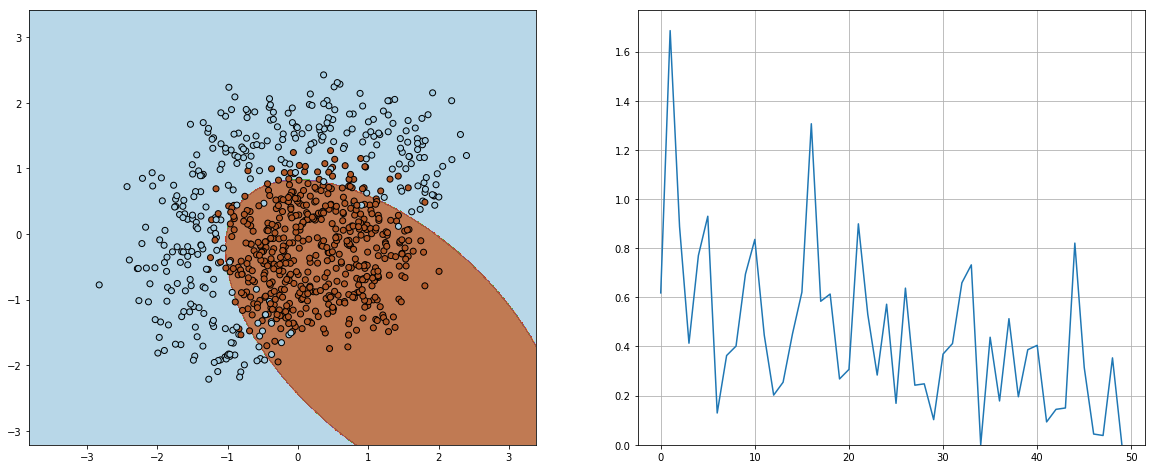

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.1 # learning rate

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)

with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        grad = compute_grad(X[ind], y[ind], w)
        w = sess.run(w - grad * alpha)

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum and test it's performance for different learning rate and momentum values.

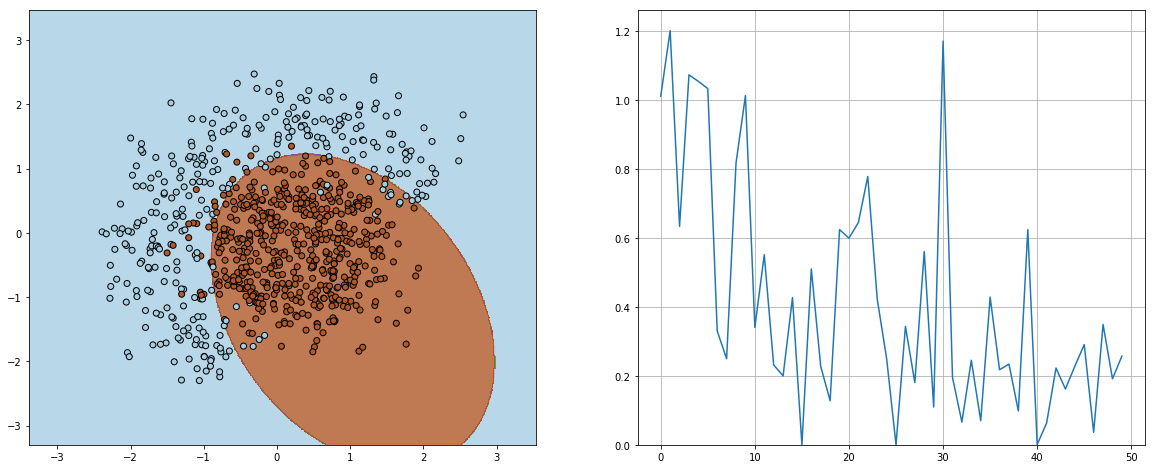

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.05 # learning rate
mu    = 0.6 # momentum

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)
v = np.array(0., dtype=np.float32)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        grad = compute_grad(X[ind], y[ind], w)
        v = mu * v - alpha * grad
        w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for Nesterov's accelerated gradient:

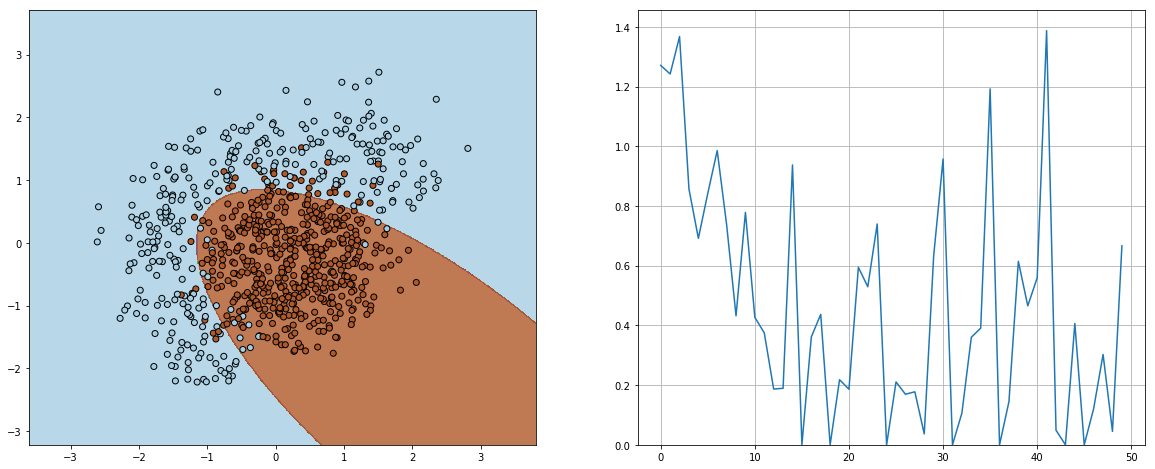

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.1 # learning rate
mu    = 0.6 # momentum

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)
v = np.zeros_like(w, dtype=np.float32)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        w_ahead = w + mu * v
        
        grad_ahead = compute_grad(X[ind], y[ind], w_ahead)
        v = mu * v - alpha * grad_ahead
        
        w = w + v

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaGrad:

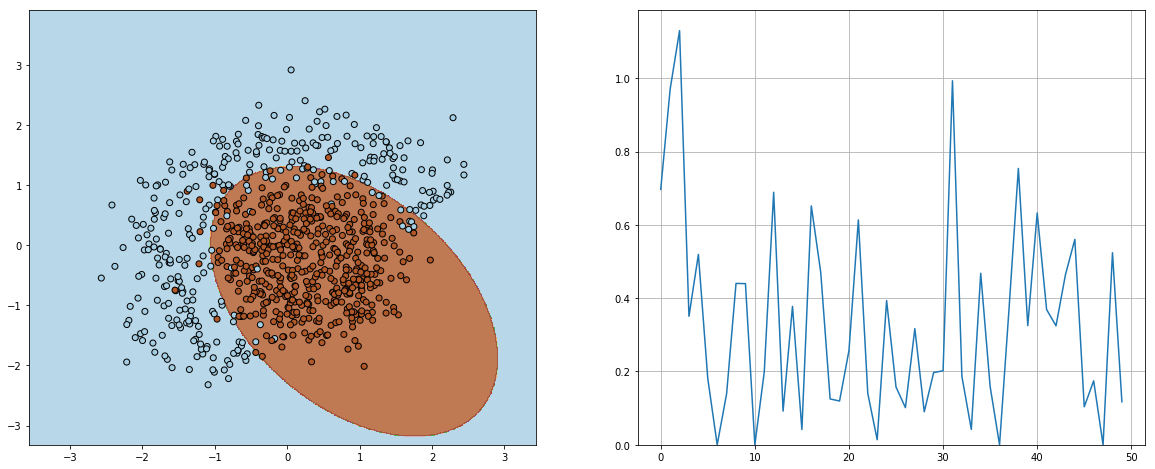

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.3 # learning rate
eps = 1e-8  # A small constant for numerical stability

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)
v = np.zeros_like(w, dtype=np.float32)

c_w = np.zeros_like(w, dtype=np.float32)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        grad = sess.run(compute_grad(X[ind], y[ind], w))
        
        c_w += grad * grad
        w += - alpha * grad / (np.sqrt(c_w) + eps)

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task but for AdaDelta:

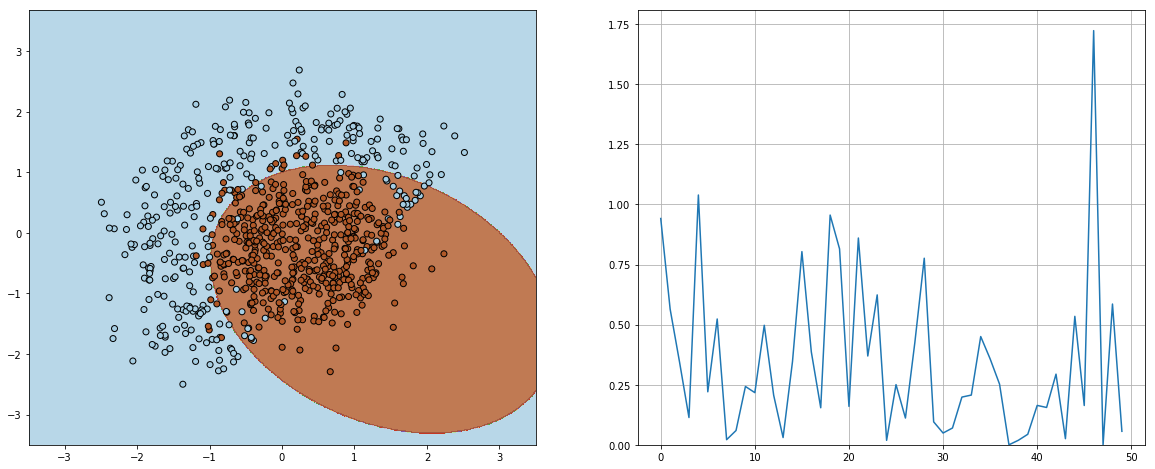

In [11]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.1 # learning rate
beta = 0.9
eps = 1e-8  # A small constant for numerical stability

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)
v = np.zeros_like(w, dtype=np.float32)

c_w = np.zeros_like(w, dtype=np.float32)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        grad = sess.run(compute_grad(X[ind], y[ind], w))
        
        c_w = beta * c_w + (1. - beta) * grad * grad
        w += - alpha / (np.sqrt(c_w) + eps) * grad

visualize(X, y, w, loss, n_iter)
plt.clf()

Same task for Adam algorithm. You can start with beta = 0.9 and mu = 0.999

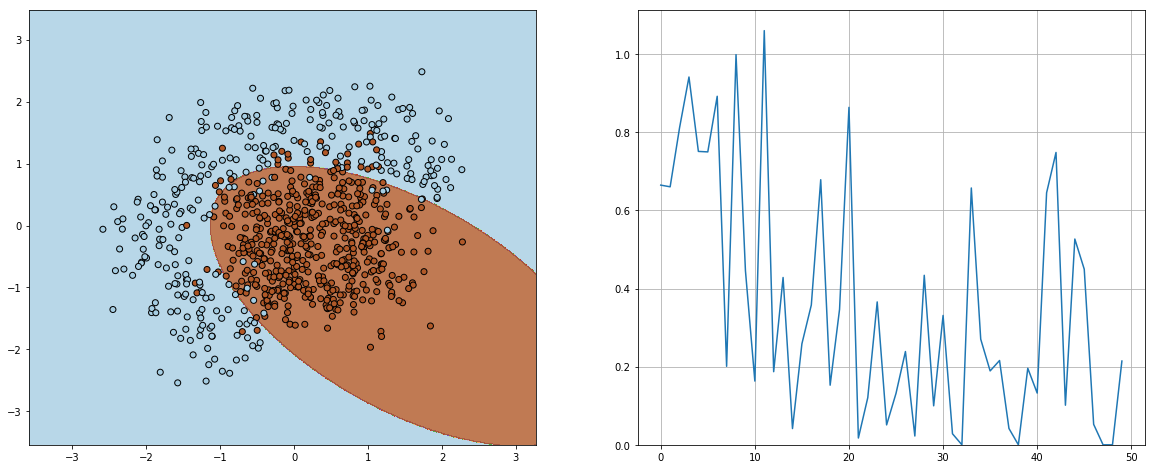

In [9]:
w = np.array([1,0,0,0,0,0], dtype=np.float32)

alpha = 0.1 # learning rate
beta = 0.95  # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu   = 0.95  # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 1e-8  # A small constant for numerical stability

X = X.astype(dtype=np.float32)
y = y.astype(dtype=np.float32)
v = np.zeros_like(w, dtype=np.float32)

c_w = np.zeros_like(w, dtype=np.float32)
v = np.zeros_like(w, dtype=np.float32)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
with tf.Session() as sess:
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = sess.run(compute_loss(X[ind], y[ind], w))
        visualize(X[ind,:], y[ind], w, loss, n_iter)

        grad = sess.run(compute_grad(X[ind], y[ind], w))
        
        v = beta * v + (1. - beta) * grad
        c_w = mu * c_w + (1. - mu) * grad * grad
        w += - alpha / (np.sqrt(c_w) + eps) * v

visualize(X, y, w, loss, n_iter)
plt.clf()